<a href="https://colab.research.google.com/github/Pouyan97/CS342-HW4/blob/master/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WOW THIS IS STUPID

In [2]:
print('stupid')

stupid


# CS 449 Deep Learning Homework 1

This assignment is due Tuesday, January 24 at 11:59pm Central Time. It is worth approximately 8% of your final grade.

While the project and some future assignments may be completed in groups, this assignment **must be completed alone**. Do not submit someone else's work as your own, and do not allow someone else to submit your work as their own.

To submit this assignment, you should commit to your GitHub account:

* your Net ID in the `netid` file. Please do not put your name in your notebook; we will grade these anonymously.

* a `hw1.pdf` printout of the completed notebook that shows all your answers. 

* your final `hw1.ipynb` notebook with outputs saved. If we run your notebook from scratch, it should produce an output identical to your PDF. You can edit your notebook however you want (on Colab, on your local machine, somewhere else); just upload the latest version of it to GitHub.

Your GitHub account must submit contain all three of these, or you will lose points. We will not accept late work except in extreme settings.


# Question 1: Loss functions (10 points)

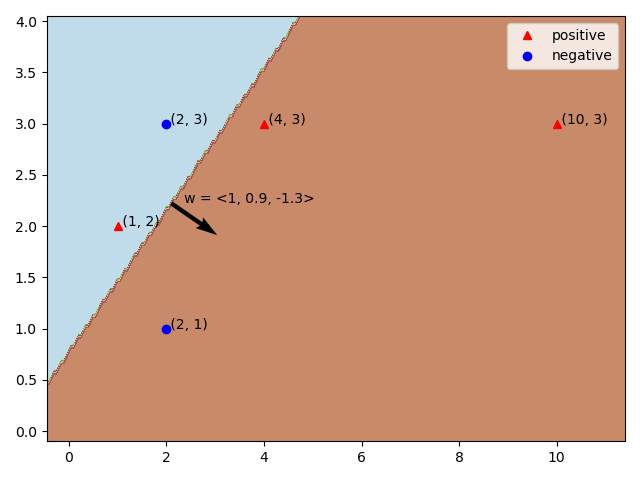

Consider the linear classifier with the weights and decision boundary above. Define $g({\bf x}) =  {\bf w}^\top {\bf x}$. We'll define our classification prediction $h({\bf X}) = \text{sign}(g({\bf X}))$. Using the parameters $\mathbf{w} = \langle 1, 0.9, -1.3 \rangle$ shown above, we can calculate $g(X)$ and $h(X)$ as:

$\begin{array}{c r r r}
{\bf X} & y & g({\bf X}) & h({\bf X}) \\
\hline
(1, 2) &  1  & -0.7 &  -1 \\
(2, 1) &  -1 & 1.5  &  1   \\
(2, 3) &  -1 & -1.1 &  -1  \\
(4, 3) &  1  & 0.7  &  1   \\
(10, 3)&  1  & 6.1  &  1 
\end{array}$

Right now, the classifier gets 60% accuracy. We want to think about how different loss functions could help the model improve.

In class, we've discussed the perceptron loss and mean squared error as ways of evaluating the quality of model predictions. First, read up on [Hinge loss](https://en.wikipedia.org/wiki/Hinge_loss) and [Binary Cross Entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) to understand how those work. We include definitions below, but it'll be helpful to understand the "margin" aspect of hinge loss and the probabilistic interpretation of BCE loss.

Using our $g({\bf X})$ definition above, we can define each loss as the following:

1. Perceptron (zero-one) loss:

$L(x, y) = \begin{cases}
0 & \text{if } y \cdot g({\bf x}) > 0 \\
1 & \text{otherwise} 
\end{cases} \\[2em]$

2. Squared error loss:

$L(x, y) = (y - g({\bf x}))^2 \\[2em]$

3. Binary cross-entropy loss (written in an atypical way):

$L(x, y) = \begin{cases}
\ln\left(1 + \exp(-g({\bf x}))\right) & \text{ if } y > 0 \\
\ln\left(1 + \exp(g({\bf x}))\right) & \text{ if } y < 0
\end{cases} \\[2em]$

4. Hinge loss:

$L(x, y) = \max\left(0, 1 - y \cdot g({\bf x})\right) \\[1em]$

For each loss, answer the following questions. You must provide an explanation for full points.

 - a. Which points have the highest loss value? Why?

 - b. Which points have the lowest loss value? Why?

 - c. Is there a different set of parameters ${\bf w'}$ that would have a lower total loss across all five points? How can you tell? If you're not sure, explain why it's hard to tell. You shouldn't need to walk through the calculations.

 - d. If we could find a different set of parameters with a lower loss value, are those parameters *guaranteed* to produce a model with accuracy greater than 60%? Why or why not?

 - e. Is this a good loss function for our task of binary classification? Why or why not?

### *Please add your answers into the structure below. You shouldn't need to write or run code for these answers.*

1. Perceptron loss

  a. ...

  b. ...

  c. ...

  d ...

  e ...

2. Squared error loss

  a. ...

  b. ...

  c. ...

  d ...

  e ...

3. Binary cross entropy loss

  a. ...

  b. ...

  c. ...

  d ...

  e ...


4. Hinge loss

  a. ...

  b. ...

  c. ...

  d ...

  e ...

# Question 2: Experiments with Pretraining (10 points)

## Code setup

Read through the code below to get a sense of how we're setting up these experiments.

Then, you can run all the cells. The questions you need to answer are found at the bottom of the notebook. 

In [ ]:
# helper code from the course repository
!cd /content && git clone -q https://github.com/zachwooddoughty/cs449w23.git
# install common pacakges used for deep learning
!cd /content/cs449w23/ && pip install -q -r requirements.txt

# this "magic" command makes graphics produced by matplotlib appear
%matplotlib inline

# make sure we're in the right directory
%cd /content/cs449w23/
# pull any updates
!git pull -q origin main

import torch
import numpy as np

import copy
import random

from collections import defaultdict
from sklearn.model_selection import train_test_split
from utils.plotting import *  # see plotting.py for plotting utilities

fatal: destination path 'cs449w23' already exists and is not an empty directory.
/content/cs449w23


In [ ]:
# Create two datasets

def make_multiple_circles(radii, examples_per_ring, std=0.1,):
    """
    A dataset of concentric circles of alternating labels
    """
    assert type(radii) in [list, tuple, np.ndarray]

    X = np.zeros([0, 2])
    y = np.zeros([0,])

    for i, radius in enumerate(radii):
        # Rings alternate as labeled -1 or 1
        y_ = np.ones([examples_per_ring]) * (-1) ** i
        y = np.concatenate([y, y_], axis=0)

        # Create a ring of points with radii centered at radius
        #   but in any random angle from the origin
        r = radius + np.random.normal(0, std, examples_per_ring)
        theta = np.random.uniform(0, 2 * np.pi, examples_per_ring)

        # Convert (r, theta) coordinates to cartesian
        x0 = r * np.sin(theta)
        x1 = r * np.cos(theta)
        x_ = np.stack([x0, x1], axis=1)
        X = np.concatenate([X, x_], axis=0)

    return X, y.astype(int)

def make_spiral(n):
    """
    Yet another spiral dataset
    """
    y0 = np.zeros(n)
    y1 = np.ones(n)
    y = np.concatenate([y0, y1], axis=0).astype(int)
    z = np.concatenate(2 * [np.linspace(0, 4 * np.pi, n)], axis=0)

    x0 = z * np.sin(z + y * np.pi)
    x1 = z * np.cos(z + y * np.pi)
    X = np.stack([x0, x1], axis=1)

    y[y == 0] = -1

    return X, y

def numpy_to_tensor(lst):
    """
    Convert numpy array to torch tensor
    """
    if type(lst) == np.ndarray:
        return torch.tensor(lst).to(dtype=torch.float32)

    else:
        out = [torch.tensor(item).to(dtype=torch.float32) for item in lst]
        return tuple(out)

In [ ]:
class HW1Net(torch.nn.Module):
    def __init__(self, layer_sizes=[], activation=torch.tanh):
        """
        Construct a simple neural network.

        Args:
         - layer_sizes: a list or tuple of hidden layer sizes. For example,
                        if layer_sizes = [4, 4], this will be a network
                        with linear layers with dimensions[2, 4], [4, 4], [4, 2]
         - activation:  a torch activation function
        """
        super().__init__()

        input_dims = (2, ) + tuple(layer_sizes)
        output_dims = tuple(layer_sizes) + (2, )
        dims = zip(input_dims, output_dims)

        self.activation = activation
        self.layers = []
        for i, (input_dim, output_dim) in enumerate(dims):
            # Create and initialize the layer
            layer = torch.nn.Linear(input_dim, output_dim)
            torch.nn.init.xavier_uniform_(layer.weight)
            self.layers.append(layer)

            # Register this layer so Pytorch tracks its parameters
            setattr(self, f"layer{i}", layer)

    def forward(self, x):
        n_layers = len(self.layers)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # Activation on everything but the final layer
            if i + 1 < n_layers:
                x = self.activation(x)

        return x

In [ ]:
def run_one_epoch(model, optimizer, X, y, train=True):

    if train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    output = model(X).squeeze()
    binary_targets = torch.where(y > 0, 1, 0)
    acc = torch.sum(torch.argmax(output, dim=1) == binary_targets) / y.size(0)
    loss = torch.nn.CrossEntropyLoss()(output, binary_targets)

    if train:
        loss.backward()
        optimizer.step()

    # Detach tells torch to stop tracking a tensor's gradients
    return acc.detach(), loss.detach()

In [ ]:
def pretrain_and_train(pretrain_data, data, **kwargs):

    # Create the model and set up the optimizer
    model = HW1Net(
        layer_sizes=kwargs["layer_sizes"],
        activation=kwargs["activation"],
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs["learning_rate"])

    # Pretrain the model and save a copy of the pretrained model
    X, y = pretrain_data
    for _ in range(kwargs["n_pretrain_epochs"]):
        run_one_epoch(model, optimizer, X, y)
    pretrained_model = copy.deepcopy(model)

    # Train the model and track its performance over each epoch
    results = defaultdict(list)
    X_train, X_test, y_train, y_test = data
    for i in range(kwargs["n_train_epochs"]):
        train_acc, train_loss = run_one_epoch(
            model, optimizer, X_train, y_train)
        
        test_acc, test_loss = run_one_epoch(
            model, None, X_test, y_test, train=False)

        results["train_acc"].append(train_acc)
        results["test_acc"].append(test_acc)
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return pretrained_model, model, results

In [ ]:
def make_prediction_function(model):
    """
    Our network outputs real-valued logits
    When we make final predictions, those should be +1 or -1
    """
    def predict(X):
        X = numpy_to_tensor(X)
        output = model(X).detach()
        binary_pred = np.argmax(output, axis=1)
        return np.where(binary_pred > 0, 1, -1)

    return predict

def plot_results(pretrained_model, trained_model,
                pretrain_data, data,
                results, title):
    """
    Given a (saved) pretrained model, our final trained model,
        the pretrained data, train and test data,
        and a dictionary of results,

    Build the six-panel figure that you'll use to show off your results.
    """
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12),
                             constrained_layout=True)

    X_pretrain, y_pretrain = pretrain_data
    X_train, X_test, y_train, y_test = data

    # Top right panel
    ax = axes[0, 1]
    ax.set_title("Pretrained Model on Train Data")
    plot_data(X_train, y_train, ax)
    predict = make_prediction_function(pretrained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Top left panel
    ax = axes[0, 0]
    ax.set_title("Pretrained Model on Pretrain Data")
    plot_data(X_pretrain, y_pretrain, ax)
    axes[0, 0].set_ylim(axes[0, 1].get_ylim())
    axes[0, 0].set_xlim(axes[0, 1].get_xlim())
    predict = make_prediction_function(pretrained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Middle left panel
    ax = axes[1, 0]
    ax.set_title("Trained Model on Train Data")
    plot_data(X_train, y_train, ax)
    predict = make_prediction_function(trained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Middle right panel
    ax = axes[1, 1]
    ax.set_title("Trained Model on Test Data")
    plot_data(X_test, y_test, ax)
    predict = make_prediction_function(trained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Bottom left
    ax = axes[2, 0]
    ax.set_title("Loss per Epoch")
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    n_epochs = len(train_loss)
    ax.plot(np.arange(n_epochs), train_loss, c='r', label='Train Loss')
    ax.plot(np.arange(n_epochs), test_loss, c='b', label='Test Loss')
    ax.legend(loc="best")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, 2 * ymax)

    # Bottom right
    ax = axes[2, 1]
    ax.set_title("Accuracy per Epoch")
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    n_epochs = len(train_acc)
    ax.plot(np.arange(n_epochs), train_acc, c='r', label='Train Acc')
    ax.plot(np.arange(n_epochs), test_acc, c='b', label='Test Acc')
    ax.legend(loc="best")
    ax.set_ylim(0, 1.1)

    final_accuracy = np.mean(test_acc[-10:])
    final_accuracy = f"Final mean test acc: {100 * final_accuracy:.1f}%"
    ax.annotate(final_accuracy, xy=(0, 0.3),
                textcoords="data", fontsize=16)

    plt.suptitle(title, fontsize=24)
    plt.show()

In [ ]:
def run_experiment(**kwargs):
    """
    Required kwargs:
    - title:                A name for this experiment

    - radii:                radii of rings in the multiple_circles dataset
    - examples_per_ring:    number of examples per ring

    - examples_per_spiral:  number of examples per spiral

    - layer_sizes:          number of nodes per hidden layer in network
    - activation:           activation function for each hidden layer
    - learning_rate:        learning rate for SGD optimization
    - n_pretrain_epochs:    how many epochs to pretrain
    - n_train_epochs:       how many epochs to train
    """
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)

    pretrain_data = make_multiple_circles(
        radii=kwargs['radii'], examples_per_ring=kwargs['examples_per_ring']
    )
    pretrain_data = numpy_to_tensor(pretrain_data)

    spiral_data = make_spiral(kwargs["examples_per_spiral"])
    spiral_data = numpy_to_tensor(train_test_split(*spiral_data, test_size=0.2))

    pretrained_model, trained_model, results = pretrain_and_train(
        pretrain_data, spiral_data, **kwargs)
    
    plot_results(pretrained_model, trained_model,
                 pretrain_data, spiral_data,
                 results, kwargs["title"])

/content/cs449w23/utils/plotting.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  data.T[0, pos_idx],


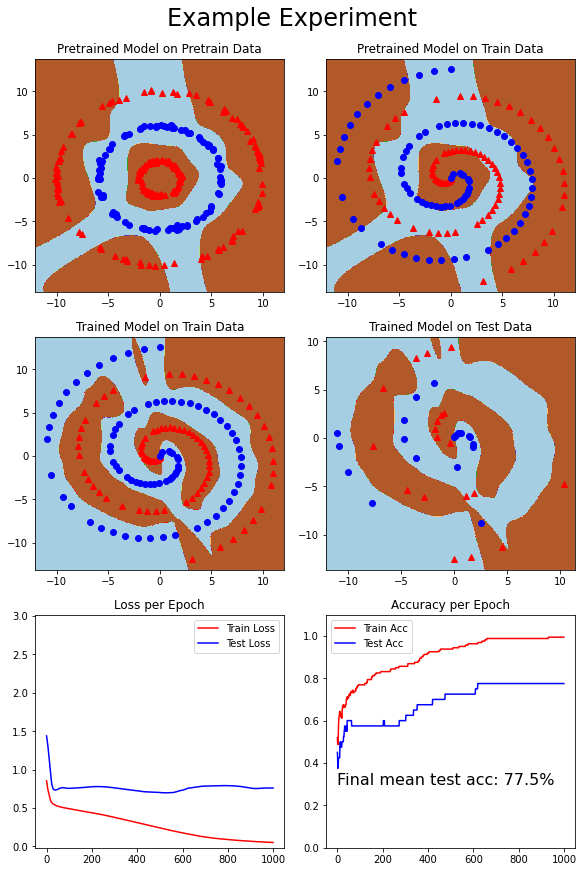

In [ ]:
# Example experiment; you should copy this cell several times,
#   edit the kwargs, and save the figure outputs to your notebook.
kwargs = {
    "title": "Example Experiment",
    "radii": (2, 6, 10),
    "examples_per_ring": 100,
    "examples_per_spiral": 100,
    "layer_sizes": [100, 10],
    "activation": torch.tanh,
    "learning_rate": 0.001,
    "n_pretrain_epochs": 300,
    "n_train_epochs": 1000,
}

run_experiment(**kwargs)

## Understanding the Code (2 points)

1. In the provided code, the network outputs a real-valued tensor of shape `(N, 2)`. In the `run_one_epoch` function, we use a combination of `where`, `argmax`, and `torch.nn.CrossEntropyLoss`. How do these calculations work? You may want to look at the [documentation for the loss function](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

2. Read through the `run_experiment`, `pretrain_and_train`, and `plot_results` functions to understand how the figure is being built. In your own words, describe in general what the six panels show. What data is being used in which panels? 

*Please put your answers to "Understanding the Code" here*

## Experiments and Discussion (8 points)

The example experiment we provide has the following keyword arguments:

```
kwargs = {
    "title": "Example Experiment",
    "radii": (2, 6, 10),
    "examples_per_ring": 100,
    "examples_per_spiral": 100,
    "layer_sizes": [100, 10],
    "activation": torch.tanh,
    "learning_rate": 0.001,
    "n_pretrain_epochs": 300,
    "n_train_epochs": 1000,
}
```

For your experiments, you should change these values and rerun `run_experiment(**kwargs)` and track what happens. You can run as many or as few experiments as you want, but they should have unique `title` values (i.e., not "Example Experiment"), and your written answers to the following questions should reference the figures produced by specific experiments. That is, don't say "the model tends to overfit"; say "in my `Example #4` above, we can see that the model is overfitting because ...". You can copy the example experiment we provide into new Code cells, edit the kwargs, and run the cell to save the output to your notebook.

1. **Overfitting Experiments** (2 points)

    Include at least two experiments that show the model overfitting.
    Describe what those experiments show and how you know the model is
    overfitting. What arguments had the most effect on whether your
    model overfits?

*Please put your "Overfitting Experiments" answer here*


2. **Best Experiment** (3 points)

    Across all the experiments you ran, with which arguments did you achieve the highest "Final mean test acc"? What patterns led you to find these arguments? Which arguments had the largest impact on your experimental results? What was more difficult than you expected?

    Your answer should be at least two paragraphs and reference at least three different experiments you ran.

*Please put your "Best Experiment" answer here*




3. **Pretraining Experiments** (3 points)

    The point of pretraining is to get the model "started" with an easier task (rings) so it can more quickly learn the task we care about (spirals). You can control the amount of ring data, the amount of spiral data, and the number of epochs the model train on each. In your experiments, assume that all we care about is maximizing the final mean test set accuracy.

    Based on your experiments, **when does pretraining help? When does it hurt?**

    Your answer should be at least two paragraphs and reference at least three different experiments you ran.

*Please put your "Pretraining Experiments" answer here*